In [2]:
from src.components.nn_data_ingestion import FraudDetectionDataset,SequentialFraudDetectionDataset,BaggingSequentialFraudDetectionDataset
from src.components.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader
from src.components.features_engineering import PreprocessorPipeline
from src.components.utils import setup_logger
import pandas as pd
import os
import torch

from src.models.feed_forward_nn import Feed_Forward_NN
logger = setup_logger()

In [3]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())
batch_size = 2048
epoch = 40
patience = 10
pos_mul = 1
train_duration=35
test_duration=7
start_date = "2018-07-01"
end_train_date = "2022-12-31"
start_test_date = "2018-04-01"
end_test_date = "2018-06-23"

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_upsampled_data",
    start_train_date=start_date,
    end_train_date= end_train_date,
    end_test_date= end_test_date,
    start_test_date= start_test_date)

train_preprocessed = PreprocessorPipeline(train_df,add_method=["scale"]).process()
validation_preprocessed = PreprocessorPipeline(validation_df,add_method=['scale']).process()
pos_weight = pos_mul * 1/torch.tensor(train_preprocessed[DataIngestorConfig().output_feature].sum()
                            / (len(train_preprocessed) - train_preprocessed[DataIngestorConfig().output_feature].sum()))

pos = train_df[DataIngestorConfig().output_feature].sum()
pos_processed = train_preprocessed[DataIngestorConfig().output_feature].sum()
train_data = FraudDetectionDataset(train_preprocessed, mode="transformed")
validation_data = FraudDetectionDataset(validation_preprocessed, mode="transformed")

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    persistent_workers=True
)
validation_loader = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False)


c:\Users\thuhi\workspace\fraud_detection
2025-06-27 11:50:35,530 - INFO - Train: 2018-07-01 - 2022-12-31
2025-06-27 11:50:47,528 - INFO - Test: 2018-04-01 - 2018-06-23


In [6]:
checkpoint = rf"C:\Users\thuhi\workspace\fraud_detection\checkpoints\best-model-20250627_110857-ffnnepoch=00-val_loss=1.20.ckpt"
model = Feed_Forward_NN.load_from_checkpoint(checkpoint_path=checkpoint,input_size=len(train_data.config.input_features_transformed), hidden_size=512,pos_weight=pos_weight)

     AUCROC        F1  Top100k_Precision
0  0.666607  0.018936              0.972
Middle range samples: 805547


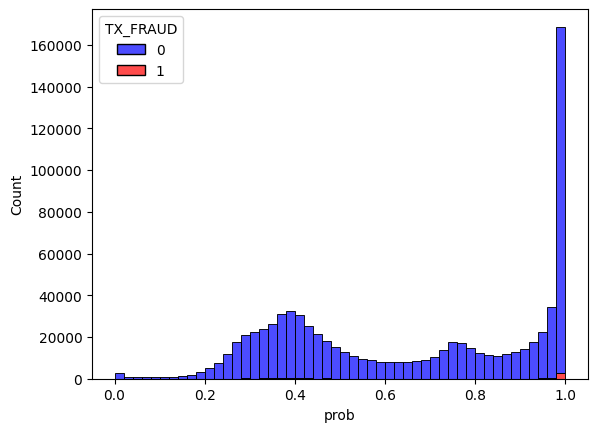

In [7]:

# Normalize if needed (replace with your training mean/std)
# mean = torch.tensor(train_mean)
# std = torch.tensor(train_std)
# test_data = (test_data - mean) / std

# Load the model

model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for batch in validation_loader:
        # If your dataset returns (X, y), unpack it
        if isinstance(batch, (tuple, list)):
            X = batch[0]
        else:
            X = batch
        # If X is a list of tensors, move each to device
        if isinstance(X, list):
            X = [x.to(model.device) for x in X]
        else:
            X = X.to(model.device)
        y_hat = model(X)
        y_prob = torch.sigmoid(y_hat).squeeze(-1)
        y_pred = (y_prob > 0.5).float()
        all_probs.append(y_prob.cpu())
        all_preds.append(y_pred.cpu())

# Concatenate all predictions
import torch
y_prob = torch.cat(all_probs)
y_pred = torch.cat(all_preds)

predicted_proba = pd.DataFrame(y_prob.cpu())
validation_preprocessed.reset_index(drop=True,inplace=True)
validation_preprocessed["prob"] = predicted_proba
validation_preprocessed["TX_FRAUD"].value_counts()
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, precision_score

# AUC-ROC
y_true = validation_preprocessed["TX_FRAUD"].values
y_scores = validation_preprocessed["prob"].values

aucroc = roc_auc_score(y_true, y_scores)

# F1 score at threshold 0.5
y_pred_bin = (y_scores > 0.5).astype(int)
f1 = f1_score(y_true, y_pred_bin)

# Top 100k precision
top_k = 1000                                                                                                                                                                                                                                                                                                                                                                
top_k_idx = y_scores.argsort()[-top_k:][::-1]
precision_top_k = precision_score(y_true[top_k_idx], y_pred_bin[top_k_idx])

# Report as DataFrame
metrics_df = pd.DataFrame({
    "AUCROC": [aucroc],
    "F1": [f1],
    "Top100k_Precision": [precision_top_k]
})
print(metrics_df)
print(f"Middle range samples: {len(validation_preprocessed)}")

filtered_df = validation_preprocessed
if not filtered_df.empty:
    sns.histplot(
        data=filtered_df,
        x="prob",                              
        hue="TX_FRAUD",
        multiple="stack",
        bins=50,
        palette={0: "blue", 1: "red"},
        alpha=0.7
    )
else:
    print("No samples with prob >= 0.5 to plot.")


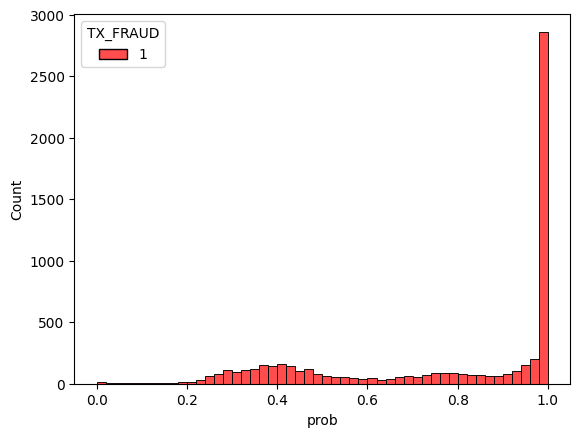

In [8]:

# Normalize if needed (replace with your training mean/std)
# mean = torch.tensor(train_mean)
# std = torch.tensor(train_std)
# test_data = (test_data - mean) / std

# Load the model
validation_preprocessed_fraud = validation_preprocessed[validation_preprocessed["TX_FRAUD"]==1]
validation_data = FraudDetectionDataset(validation_preprocessed_fraud,mode="transformed")
    
batch_size = 512

validation_loader = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False,
    pin_memory= True,
    prefetch_factor=6

)
model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for batch in validation_loader:
        # If your dataset returns (X, y), unpack it
        if isinstance(batch, (tuple, list)):
            X = batch[0]
        else:
            X = batch
        # If X is a list of tensors, move each to device
        if isinstance(X, list):
            X = [x.to(model.device) for x in X]
        else:
            X = X.to(model.device)
        y_hat = model(X)
        y_prob = torch.sigmoid(y_hat).squeeze(-1)
        y_pred = (y_prob > 0.5).float()
        all_probs.append(y_prob.cpu())
        all_preds.append(y_pred.cpu())

# Concatenate all predictions
import torch
y_prob = torch.cat(all_probs)
y_pred = torch.cat(all_preds)

predicted_proba = pd.DataFrame(y_prob.cpu())
validation_preprocessed_fraud.reset_index(drop=True,inplace=True)
validation_preprocessed_fraud["prob"] = predicted_proba
validation_preprocessed_fraud["TX_FRAUD"].value_counts()
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, precision_score



# F1 score at threshold 0.5
y_pred_bin = (y_scores > 0.5).astype(int)
f1 = f1_score(y_true, y_pred_bin)

# Top 100k precision
top_k = 1000                                                                                                                                                                                                                                                                                                                                                                
top_k_idx = y_scores.argsort()[-top_k:][::-1]
precision_top_k = precision_score(y_true[top_k_idx], y_pred_bin[top_k_idx])

filtered_df = validation_preprocessed_fraud
if not filtered_df.empty:
    sns.histplot(
        data=filtered_df,
        x="prob",
        hue="TX_FRAUD",
        multiple="stack",
        bins=50,
        palette={0: "blue", 1: "red"},
        alpha=0.7
    )
else:
    print("No samples with prob >= 0.5 to plot.")


In [9]:
import torch
import numpy as np # Import numpy for formatting the printout

def debug_forward_gating(model, x):
    """
    Performs a forward pass for the GATING-based model and prints the logits
    and gating weights from each component.
    """
    customer_history, terminal_history, current_tx = x

    # --- 1. Get Embeddings and Individual Expert Logits (as before) ---
    cust_embedded = model.customer_embedding(customer_history).permute(0, 2, 1)
    cust_cnn_out = model.customer_cnn(cust_embedded)
    customer_logit = model.customer_expert(cust_cnn_out)

    term_embedded = model.terminal_embedding(terminal_history).permute(0, 2, 1)
    term_cnn_out = model.terminal_cnn(term_embedded)
    terminal_logit = model.terminal_expert(term_cnn_out)
    
    current_tx_logit = model.current_tx_expert(current_tx)

    # --- 2. Replicate the Gating Logic from your model's forward pass ---
    
    # Create the input for the gating network from the 'evidence'
    gate_input = torch.cat([cust_cnn_out, term_cnn_out, current_tx], dim=1)
    # Get the trust distribution (weights) from the gating network
    expert_weights = model.gating_network(gate_input)

    # --- 3. Calculate the Final Logit using the Gating Weights ---
    
    # Concatenate the 'opinions' (the logits)
    expert_logits = torch.cat([customer_logit, terminal_logit, current_tx_logit], dim=1)
    
    # Calculate the final logit as a weighted sum of the expert opinions
    final_logits = torch.sum(expert_weights * expert_logits, dim=1, keepdim=True)
    
    # --- 4. Calculate Probabilities for Reporting ---
    final_prob = torch.sigmoid(final_logits)
    cust_prob = torch.sigmoid(customer_logit)
    term_prob = torch.sigmoid(terminal_logit)
    tx_prob = torch.sigmoid(current_tx_logit)

    # --- 5. Print Enhanced Report ---
    print("--- DEBUGGING GATING MODEL INTERNALS ---")
    # Format the weights for easy reading
    weights_np = expert_weights.detach().cpu().numpy()[0]
    print(f"Gating Weights (C/T/TX): [{weights_np[0]:.2f} / {weights_np[1]:.2f} / {weights_np[2]:.2f}]")
    print("---------------------------------")
    print(f"Customer History -> Logit: {customer_logit.item():.4f} | Prob: {cust_prob.item():.4f}")
    print(f"Terminal History -> Logit: {terminal_logit.item():.4f} | Prob: {term_prob.item():.4f}")
    print(f"Current TX       -> Logit: {current_tx_logit.item():.4f} | Prob: {tx_prob.item():.4f}")
    print("---------------------------------")
    print(f"Final Combined Logit: {final_logits.item():.4f}")
    print(f"Final Fraud Probability: {final_prob.item():.4f}")


def debug_single_sample(model, dataset, index: int):
    """
    Selects a single sample from a dataset by index, formats it correctly,
    and runs it through the debug_forward_gating function.
    (This function does not need significant changes, only the call at the end)
    """
    print(f"=========================================")
    print(f"    ANALYZING SAMPLE AT INDEX: {index}    ")
    print(f"=========================================")

    # Get sample and true label (unchanged)
    sample_inputs, sample_target = dataset[index]
    try:
        true_label = sample_target[2].item()
    except (TypeError, IndexError):
        true_label = sample_target.item()
    print(f"Ground Truth Label: {true_label}")
    print("---------------------------------")

    # Unpack inputs (unchanged)
    cust_hist, term_hist, curr_tx = sample_inputs
    
    # Prepare input for the model (unchanged)
    model_device = next(model.parameters()).device
    batched_input = (
        cust_hist.unsqueeze(0).long().to(model_device),
        term_hist.unsqueeze(0).long().to(model_device),
        curr_tx.unsqueeze(0).to(model_device)
    )

    # Run the NEW debugging function in no_grad mode
    with torch.no_grad():
        debug_forward_gating(model, batched_input)
    print("\n")

# --- EXAMPLE USAGE ---
# This would go in your main inference/analysis script

# 1. Load your GATING model and dataset
# model = BaggingCNN_FFNN.load_from_checkpoint("path/to/your/gating_model.ckpt")
# validation_data = YourDataset(...)

# 2. Set the model to evaluation mode
# model.eval()

# 3. Pick an index and debug
# index_to_check = 50
# debug_single_sample(model, validation_data, index_to_check)

In [10]:
from torch.utils.data import Dataset
import numpy as np
class BaggingSequentialDataset(Dataset):
    def __init__(self, df: pd.DataFrame, c_seq_len=5,t_seq_len=5,mode=None):

        self.mode =mode
        self.config = DataIngestorConfig()
        
        self.t_historical_len = t_seq_len - 1
        self.c_historical_len = c_seq_len - 1
        self.df_source = df.copy().sort_values("TX_DATETIME").reset_index(drop=True)
        self.num_samples = len(self.df_source)

        # --- 1. Prepare Target and Current Transaction Features ---
        self.targets = torch.tensor(self.df_source[self.config.output_feature].values, dtype=torch.int8)
        target_padding = torch.zeros(1, dtype=torch.float32)
        self.targets = torch.hstack([self.targets, target_padding])
        # The "current" stream gets all transformed features
        self.current_tx_features = torch.tensor(self.df_source[self.config.input_features_transformed].values, dtype=torch.float32)

        # --- 2. Prepare Customer History Stream ---
        customer_features_tensor = torch.tensor(self.df_source[self.config.input_features_customer].values, dtype=torch.float32)
        cust_padding = torch.zeros(1, customer_features_tensor.shape[1], dtype=torch.float32)
        self.customer_features_pool = torch.vstack([customer_features_tensor, cust_padding])
        cust_padding_idx = len(self.customer_features_pool) - 1

        # --- 3. Prepare Terminal History Stream ---
        terminal_features_tensor = torch.tensor(self.df_source[self.config.input_features_terminal].values, dtype=torch.float32)
        term_padding = torch.zeros(1, terminal_features_tensor.shape[1], dtype=torch.float32)
        self.terminal_features_pool = torch.vstack([terminal_features_tensor, term_padding])
        term_padding_idx = len(self.terminal_features_pool) - 1

        # --- 4. Create Index Mappings for Both History Types ---
        df_for_indices = pd.DataFrame({
            'CUSTOMER_ID': self.df_source['CUSTOMER_ID'],
            'TERMINAL_ID': self.df_source['TERMINAL_ID'],
            'tmp_idx': np.arange(self.num_samples)
        })

        # Customer history indices (looks back 1 to `historical_len` steps)
        cust_groupby = df_for_indices.groupby('CUSTOMER_ID')
        cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, self.c_historical_len + 1)}
        self.customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(cust_padding_idx).values, dtype=torch.long)
        
        # Terminal history indices (looks back 1 to `historical_len` steps)
        term_groupby = df_for_indices.groupby('TERMINAL_ID')
        term_sequences = {f"tx_{i}": term_groupby['tmp_idx'].shift(i) for i in range(1, self.t_historical_len + 1)}
        self.terminal_indices = torch.tensor(pd.DataFrame(term_sequences).fillna(term_padding_idx).values, dtype=torch.long)


    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        # --- Assemble Customer History ---
        cust_hist_indices = self.customer_indices[index]
        customer_history_seq = self.customer_features_pool[cust_hist_indices]

        # --- Assemble Terminal History ---
        term_hist_indices = self.terminal_indices[index]
        terminal_history_seq = self.terminal_features_pool[term_hist_indices]

        # --- Get Current Transaction Info ---
        current_tx = self.current_tx_features[index]

        # --- Get Target Label ---
        target = self.targets[index]
        if not self.mode:
            return (customer_history_seq, terminal_history_seq, current_tx), target
        if self.mode =="eda":
            return (customer_history_seq, terminal_history_seq, current_tx), (self.targets[cust_hist_indices],self.targets[term_hist_indices],self.targets[index]),(term_hist_indices,cust_hist_indices)
      
validation = BaggingSequentialDataset(df = validation_preprocessed,mode="eda",c_seq_len=7,t_seq_len=14)

In [ ]:
validation_data = BaggingSequentialFraudDetectionDataset(validation_preprocessed, t_seq_len= t_seq_len,c_seq_len=c_seq_len,mode="target")
df1 =validation_preprocessed[(validation_preprocessed["prob"]>=0.5) &(validation_preprocessed["prob"]<=1) &(validation_preprocessed["TX_FRAUD"]==1)].sort_values(["CUSTOMER_ID","TX_DATETIME"])
df_source = validation.df_source
df_source[(df_source["CUSTOMER_ID"]==3050  )&(df_source["TX_FRAUD"]==1)]


NameError: name 't_seq_len' is not defined

: 

<Axes: >

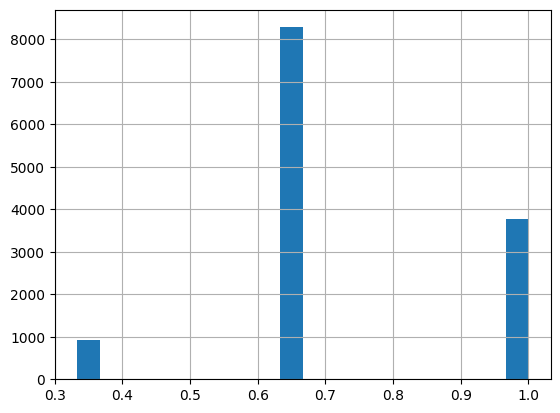

In [ ]:
df1["TX_FRAUD_SCENARIO"].hist(bins=20)

In [ ]:
df_source[df_source["TX_FRAUD"]==1].groupby("CUSTOMER_ID")["TRANSACTION_ID"].count().sort_values(ascending=True)

CUSTOMER_ID
0        1
2431     1
2430     1
2423     1
2415     1
        ..
365     36
1743    38
27      40
1692    40
3570    44
Name: TRANSACTION_ID, Length: 3414, dtype: int64

In [ ]:
# --- EXAMPLE USAGE ---
# This would go in your main inference/analysis script

# 2. Set the model to evaluation mode (very important!)
model.eval()

# 3. Pick an index to inspect and run the debug function
index_to_check = 213756								# Choose any index from your validation set
debug_single_sample(model, validation_data, index_to_check)
validation[index_to_check]
# You can even loop through a few interesting indices
# for i in [100, 500, 1234, 5678]:
#     debug_single_sample(model, validation_data, i)

    ANALYZING SAMPLE AT INDEX: 213756    
Ground Truth Label: 0
---------------------------------
--- DEBUGGING GATING MODEL INTERNALS ---
Gating Weights (C/T/TX): [0.19 / 0.44 / 0.38]
---------------------------------
Customer History -> Logit: -7.9491 | Prob: 0.0004
Terminal History -> Logit: -1.0332 | Prob: 0.2625
Current TX       -> Logit: -3.4143 | Prob: 0.0319
---------------------------------
Final Combined Logit: -3.2174
Final Fraud Probability: 0.0385




((tensor([[1.4233e-03, 1.2317e-02, 7.4011e-03, 2.5219e-02, 2.7888e-02, 3.0266e-02],
          [2.8466e-04, 5.1255e-02, 2.8466e-03, 9.0507e-02, 6.2607e-03, 1.0945e-01],
          [2.8466e-04, 5.8004e-02, 5.6931e-03, 2.7573e-01, 2.2482e-02, 3.2687e-01],
          [0.0000e+00, 1.3961e-02, 0.0000e+00, 2.9665e-02, 5.6915e-04, 4.7114e-02],
          [2.8466e-04, 4.0510e-02, 3.7005e-03, 8.3205e-02, 2.4474e-02, 1.1448e-01],
          [2.8466e-04, 4.5678e-02, 6.5471e-03, 9.4422e-02, 3.3865e-02, 1.0495e-01]]),
  tensor([[0.0000, 0.0000, 0.3571, 0.0000, 0.5366, 0.0227],
          [0.0000, 0.0000, 0.2500, 0.0000, 0.2805, 0.0000],
          [0.4000, 1.0000, 0.4643, 1.0000, 0.5366, 1.0000],
          [0.0000, 0.0000, 0.0714, 0.0000, 0.1951, 0.0000],
          [0.0000, 0.0000, 0.1786, 0.0000, 0.2195, 0.0000],
          [0.0000, 0.0000, 0.0357, 0.0000, 0.0244, 0.0000],
          [0.4000, 0.0000, 0.6429, 0.0000, 0.6463, 0.0000],
          [0.1000, 0.0000, 0.4643, 0.0000, 0.5122, 0.0000],
          [0.2